In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn import metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])


train_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = True,
                                          transform = transform,
                                          download = True)

test_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = False,
                                          transform = transform)

In [2]:
batch_size = 100
learning_rate = 0.003
num_epochs = 10

In [3]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle = False)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [5]:
model = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  

In [7]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/600], Loss: 0.3029
Epoch [1/10], Step [200/600], Loss: 0.1723
Epoch [1/10], Step [300/600], Loss: 0.0866
Epoch [1/10], Step [400/600], Loss: 0.1552
Epoch [1/10], Step [500/600], Loss: 0.1250
Epoch [1/10], Step [600/600], Loss: 0.2057
Epoch [2/10], Step [100/600], Loss: 0.1172
Epoch [2/10], Step [200/600], Loss: 0.0392
Epoch [2/10], Step [300/600], Loss: 0.1102
Epoch [2/10], Step [400/600], Loss: 0.0705
Epoch [2/10], Step [500/600], Loss: 0.0514
Epoch [2/10], Step [600/600], Loss: 0.1295
Epoch [3/10], Step [100/600], Loss: 0.2168
Epoch [3/10], Step [200/600], Loss: 0.1450
Epoch [3/10], Step [300/600], Loss: 0.1309
Epoch [3/10], Step [400/600], Loss: 0.1057
Epoch [3/10], Step [500/600], Loss: 0.0155
Epoch [3/10], Step [600/600], Loss: 0.1468
Epoch [4/10], Step [100/600], Loss: 0.0670
Epoch [4/10], Step [200/600], Loss: 0.0932
Epoch [4/10], Step [300/600], Loss: 0.0620
Epoch [4/10], Step [400/600], Loss: 0.0696
Epoch [4/10], Step [500/600], Loss: 0.1965
Epoch [4/10

In [10]:
confusion_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= 10000, shuffle = False)
model.to('cpu')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in confusion_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)

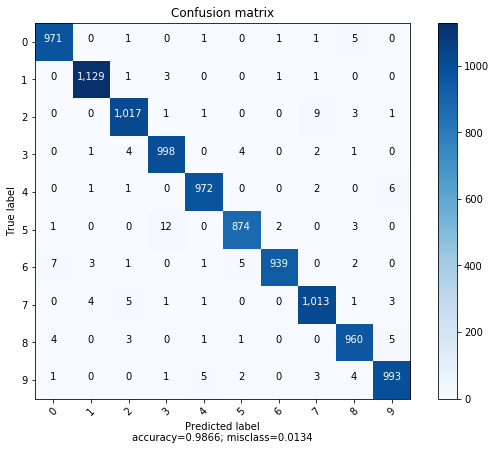

None


In [12]:
from cm_helper import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(lb, pred)
print(plot_confusion_matrix(conf_matrix,normalize =False,target_names=[0,1,2,3,4,5,6,7,8,9]))

In [13]:
print(f"The Accuracy : { 100 * metrics.accuracy_score(lb, pred)}")
print(f"The Precision : {100 * metrics.precision_score(lb, pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(lb, pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(lb, pred, average = 'macro')}")

The Accuracy : 98.66
The Precision : 98.65958215481392
The Recall : 98.64095813344804
The F1 Score : 98.64930828457453


In [ ]:
#https://www.kaggle.com/franklemuchahary/mnist-digit-recognition-using-pytorch